# Dependencies

In [1]:
import argparse

import os

import time
import torch
import pickle

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np

from model.dataloader import HELMETDataLoader
from model.dataloader import class_dict
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

from IPython.display import clear_output

# Load in model

In [2]:
cfg_path = './cfg/yolov3_36.cfg'
conv74_weights_path = './weights/darknet53.conv.74'
trained_weights_path = './weights/416e3.pt'

In [3]:
# Load in darknet.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

img_size = 416

model = get_darknet(img_size=img_size)

In [4]:
cuda_enable = False
cuda_available = torch.cuda.is_available()
if cuda_enable and cuda_available:
    device = torch.device('cuda:0')
else:
    device = 'cpu'
print('Using device: ', device)

Using device:  cpu


In [5]:
# load in weights
checkpoint = torch.load(trained_weights_path, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

# Dataloader

In [6]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=batch_size, resize=(img_size, img_size))

# Dataloader unit test

In [7]:
batch = next(iter(dataloader))

imgs, targets, annotations = batch

# imgs = imgs[0].reshape(1, 3, img_size, img_size)

out = model(imgs)

print('Img shape:', imgs.shape)
print('Output shape:', out.shape)
# print('Targets shape:', targets[0].size())

Img shape: torch.Size([3, 3, 416, 416])
Output shape: torch.Size([3, 10647, 41])


In [8]:
(13*13 + 26*26 + 52*52) * 3

10647

In [9]:
model.to(device).eval()
loss = model(imgs.to(device), targets)

# loss, model.losses

C:\Users\runes\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Test the model

### Detection hyperparamaters

In [10]:
opt = {
    'conf_thres': .5,  # Confidence threshold.
    'nms_thres': .45,   # Non-max supression.
    'iou_thres': 0.5   # IoU
}

### Make predictions

In [11]:
model.to(device).eval()
img_detections = []

# Get detections
for img in imgs:
    with torch.no_grad():
        pred = model(img.to(device).reshape(1, 3, img_size, img_size)) # pred = model(chip)
        pred = pred[pred[:, :, 4] > opt['conf_thres']]

        if len(pred) > 0:
            detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
            img_detections.extend(detections)

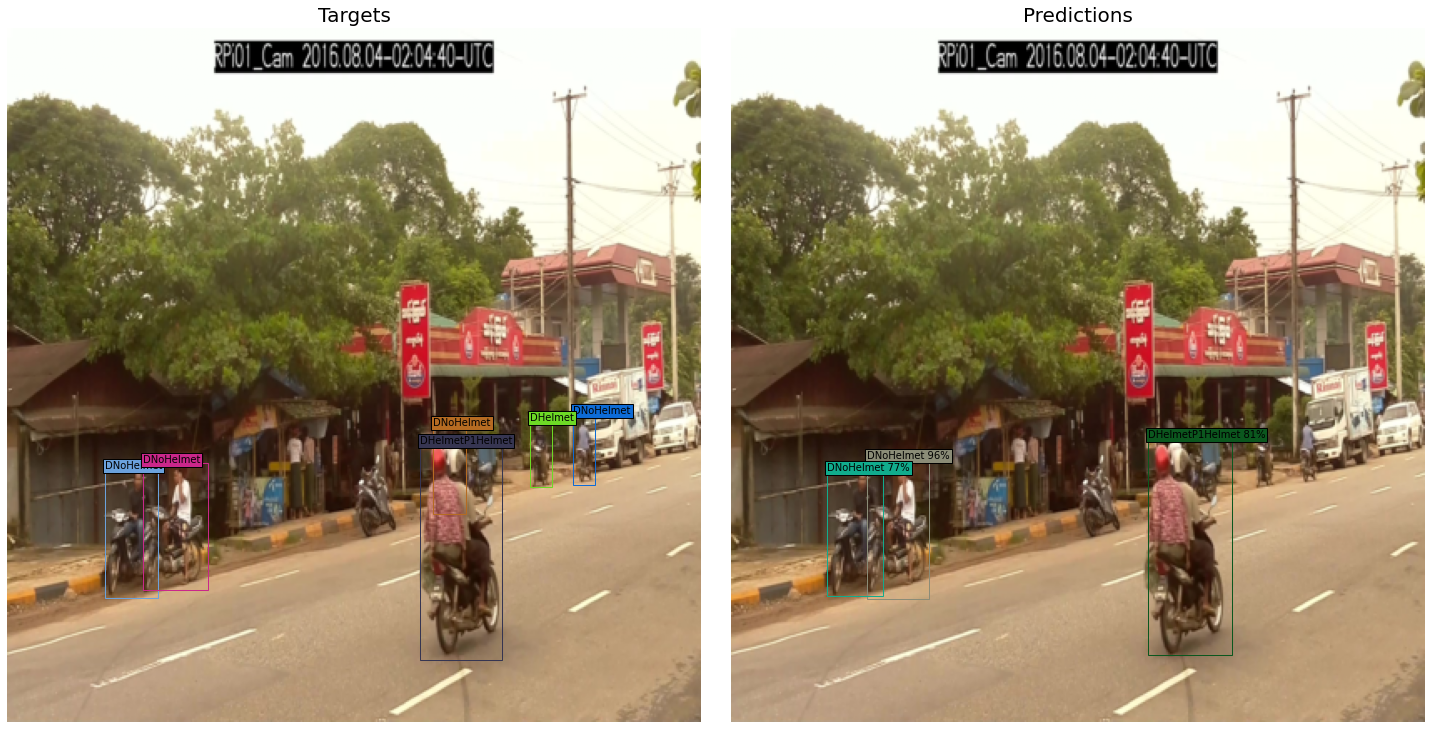

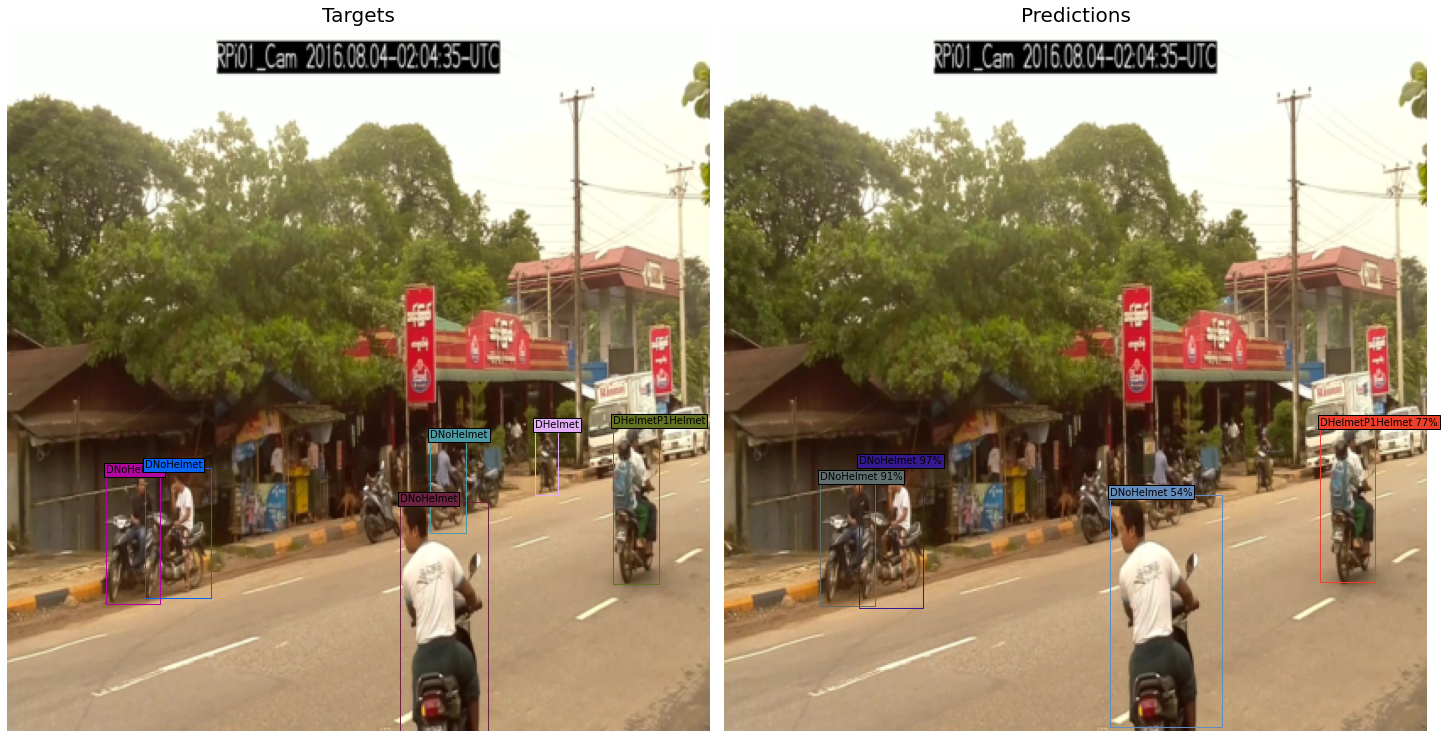

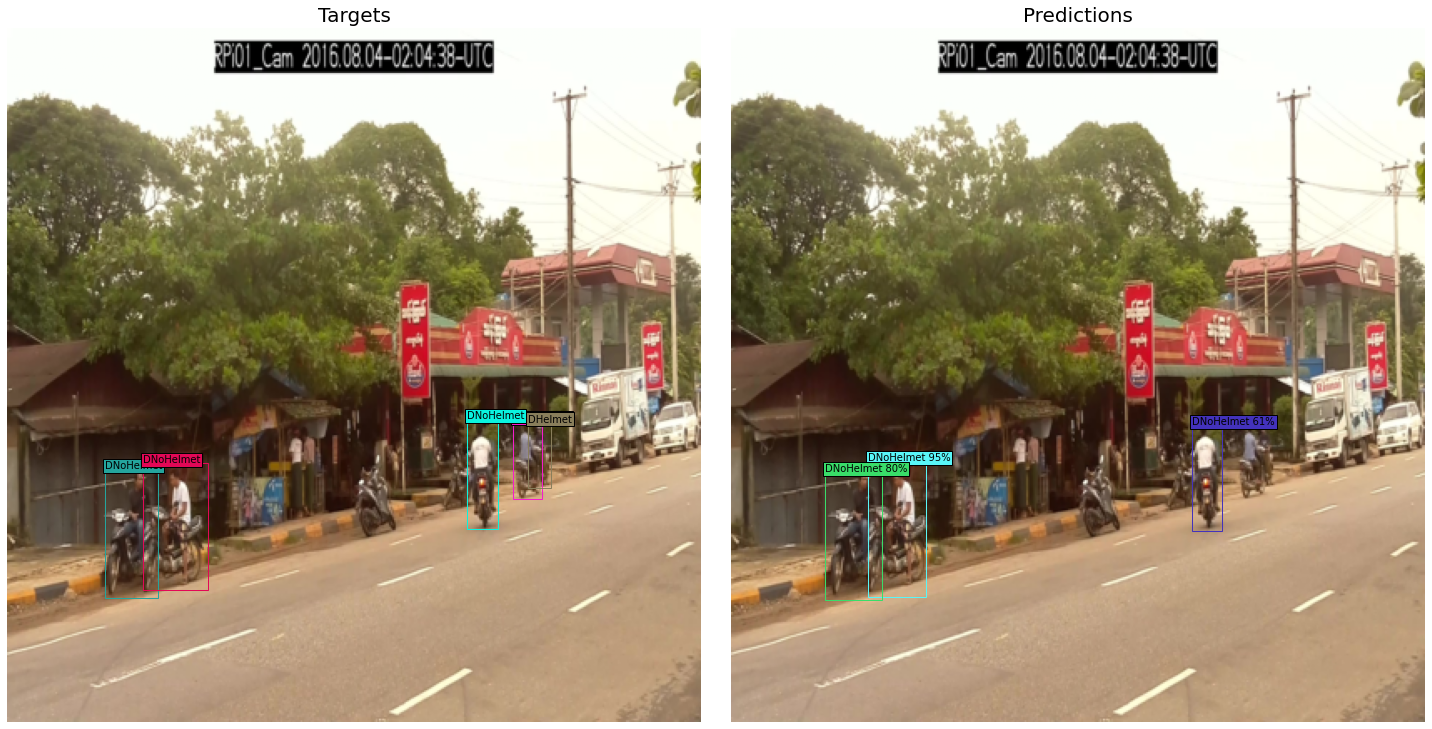

In [12]:
for img, target, detection in zip(imgs, targets, img_detections):
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

    ax1.imshow(np.array(img).transpose([1, 2, 0]))
    ax2.imshow(np.array(img).transpose([1, 2, 0]))
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Targets', fontsize=20)
    ax2.set_title('Predictions', fontsize=20)

    for label, x1, y1, box_w, box_h in target:
        # Rescale coordinates to original dimensions
        box_h = (box_h * img.shape[1]).item()
        box_w = (box_w * img.shape[2]).item()
        y1 = (y1 * img.shape[1] - box_h / 2).round().item()
        x1 = (x1 * img.shape[2] - box_w / 2).round().item()

        x1, y1 = max(x1, 0), max(y1, 0)

        label = list(class_dict.keys())[int(label)]
        col = tuple(np.random.random(3))
        rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
        ax1.add_patch(rect)
        ax1.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})
    
    # Draw bounding boxes and labels of detections
    if detection is not None:
        unique_classes = detection[:, -1].cpu().unique()

        for i in unique_classes:
            n = (detection[:, -1].cpu() == i).sum()
            # print('%g %ss' % (n, classes[int(i)]))

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:
            if len(class_dict.keys()) < int(cls_pred) - 1:
                continue

            # Rescale coordinates to original dimensions
            box_h = (y2 - y1) 
            box_w = (x2 - x1)
            
            label = list(class_dict.keys())[int(cls_pred)]
            col = tuple(np.random.random(3))
            rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
            ax2.add_patch(rect)
            ax2.text(x1, y1, label + ' ' + str( round(conf.item() * 100) ) + '%', 
                     fontsize=10, bbox={'facecolor': col, 'pad': 2})
    plt.show()

# Metrics

In [19]:
loss_dir = './loss/'
train_metric_fname = 'train_metrics'
val_metric_fname = 'val_metrics'
n_epochs = 6

train_metrics = []
val_metrics = []
for epoch in range(1, n_epochs + 1):
    train_metrics.append(pickle.load( open( loss_dir + train_metric_fname + str(epoch) + '.pickle', 'rb' ) ))
    val_metrics.append(pickle.load( open( loss_dir + val_metric_fname + str(epoch) + '.pickle', 'rb' ) ))

# Initialize concatenated dictionaries.
keys_train = train_metrics[0].keys()
keys_val = val_metrics[0].keys()
train_metrics_dict = {k: [] for k in keys_train}
val_metrics_dict = {k: [] for k in keys_val}

# Fill in the dicts
for train_metric in train_metrics:
    for k in keys_train:
        train_metrics_dict[k].append(train_metric[k])

for val_metric in val_metrics:
    for k in keys_val:
        val_metrics_dict[k].append(val_metric[k])
print('Available training metrics:', tuple(keys_train))
print('Available validation metrics:', tuple(keys_val))

Available training metrics: ('epoch', 'loss', 'x', 'y', 'w', 'h', 'conf', 'cls', 'mean_precision', 'mean_recall', 'nT', 'TP', 'FP', 'FN')
Available validation metrics: ('epoch', 'loss', 'x', 'y', 'w', 'h', 'conf', 'cls', 'mean_precision', 'mean_recall', 'nT', 'TP', 'FP', 'FN')


In [20]:
# Plot theme
sns.set_theme()

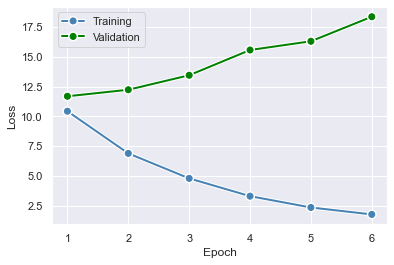

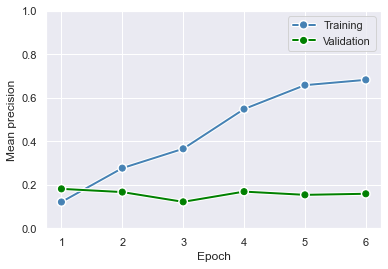

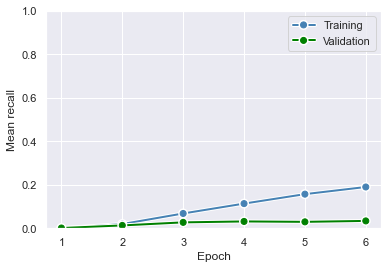

In [21]:
e = train_metrics_dict['epoch']
metrics_to_plot = [('loss', False), ('mean_precision', True), ('mean_recall', True)]
save = True

for metric, ratio in metrics_to_plot:
    # Better axis
    metric_beauty = metric.capitalize()
    metric_beauty = metric_beauty.replace('_', ' ')
    
    fig = plt.figure(figsize=(6, 4))
    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(e, train_metrics_dict[metric], '-o', label='Training', lw=2, c='steelblue', path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])
    plt.plot(e, val_metrics_dict[metric], '-o', label='Validation', lw=2, c='green', path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])
    plt.xlabel('Epoch')
    plt.ylabel(metric_beauty)
    plt.legend()
    if ratio:
        plt.ylim(0, 1)
    if save:
        plt.savefig(metric + '.png', transparent=True)
    
    plt.show()


In [16]:
print('Compute mAP...')
correct = 0
targets = None
outputs, mAPs, TP, confidence, pred_class, target_class = [], [], [], [], [], []
for batch_i, (imgs, targets, annotations) in enumerate(dataloader):
    imgs = imgs.to(device)
    
    with torch.no_grad():
        output = model(imgs)
        output = non_max_suppression(output, conf_thres=opt['conf_thres'], nms_thres=opt['nms_thres'])

    # Compute average precision for each sample
    for sample_i in range(len(targets)):
        correct = []

        # Get labels for sample where width is not zero (dummies)
        annotations = targets[sample_i]
        # Extract detections
        detections = output[sample_i]

        if detections is None:
            # If there are no detections but there are annotations mask as zero AP
            if annotations.size(0) != 0:
                mAPs.append(0)
            continue

        # Get detections sorted by decreasing confidence scores
        detections = detections[np.argsort(-detections[:, 4])]

        # If no annotations add number of detections as incorrect
        if annotations.size(0) == 0:
            target_cls = []
            #correct.extend([0 for _ in range(len(detections))])
            mAPs.append(0)
            continue
        else:
            target_cls = annotations[:, 0]

            # Extract target boxes as (x1, y1, x2, y2)
            target_boxes = xywh2xyxy(annotations[:, 1:5])
            target_boxes *= img_size

            detected = []
            for *pred_bbox, conf, obj_conf, obj_pred in detections:

                pred_bbox = torch.FloatTensor(pred_bbox).view(1, -1)
                # Compute iou with target boxes
                iou = bbox_iou(pred_bbox, target_boxes)
                # Extract index of largest overlap
                best_i = np.argmax(iou)
                # If overlap exceeds threshold and classification is correct mark as correct
                if iou[best_i] > opt['iou_thres'] and obj_pred == annotations[best_i, 0] and best_i not in detected:
                    correct.append(1)
                    detected.append(best_i)
                else:
                    correct.append(0)

        # Compute Average Precision (AP) per class
        AP = ap_per_class(tp=correct, conf=detections[:, 4], pred_cls=detections[:, 6], target_cls=target_cls)

        # Compute mean AP for this image
        mAP = AP.mean()

        # Append image mAP to list
        mAPs.append(mAP)

        # Print image mAP and running mean mAP
        print('+ Sample [%d/%d] AP: %.4f (%.4f)' % (len(mAPs), len(dataloader) * batch_size, mAP, np.mean(mAPs)))

print('Mean Average Precision: %.4f' % np.mean(mAPs))

Compute mAP...
+ Sample [1/102] AP: 0.3750 (0.3750)
+ Sample [2/102] AP: 0.2500 (0.3125)
+ Sample [3/102] AP: 0.5833 (0.4028)
+ Sample [4/102] AP: 0.5556 (0.4410)
+ Sample [5/102] AP: 0.2500 (0.4028)
+ Sample [6/102] AP: 0.2500 (0.3773)
+ Sample [7/102] AP: 0.5000 (0.3948)
+ Sample [8/102] AP: 0.5000 (0.4080)
+ Sample [9/102] AP: 0.1667 (0.3812)
+ Sample [10/102] AP: 0.1667 (0.3597)
+ Sample [11/102] AP: 0.2500 (0.3497)
+ Sample [12/102] AP: 0.2500 (0.3414)
+ Sample [13/102] AP: 0.3750 (0.3440)
+ Sample [14/102] AP: 0.3333 (0.3433)
+ Sample [15/102] AP: 0.1667 (0.3315)
+ Sample [16/102] AP: 0.3750 (0.3342)
+ Sample [17/102] AP: 0.3750 (0.3366)
+ Sample [18/102] AP: 0.3750 (0.3387)
+ Sample [19/102] AP: 0.5000 (0.3472)
+ Sample [20/102] AP: 0.3333 (0.3465)
+ Sample [21/102] AP: 0.2500 (0.3419)
+ Sample [22/102] AP: 0.0556 (0.3289)
+ Sample [23/102] AP: 0.2500 (0.3255)
+ Sample [24/102] AP: 0.2500 (0.3223)
+ Sample [25/102] AP: 0.1667 (0.3161)
+ Sample [26/102] AP: 0.3750 (0.3184)
+ Samp